In [78]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sn 
import h5py

In [79]:
def load_dataset():
    train_dataset = h5py.File('D:dnn/2/datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('D:dnn/2/datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


* train_set_x_orig ：保存的是训练集里面的图像数据（本训练集有209张64x64的图像）
* train_set_y_orig ：保存的是训练集的图像对应的分类值（【0 | 1】，0表示不是猫，1表示是猫）。
* test_set_x_orig ：保存的是测试集里面的图像数据（本训练集有50张64x64的图像）。
* test_set_y_orig ： 保存的是测试集的图像对应的分类值（【0 | 1】，0表示不是猫，1表示是猫）。
* classes ： 保存的是以bytes类型保存的两个字符串数据，数据为：[b’non-cat’ b’cat’]。

In [80]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()

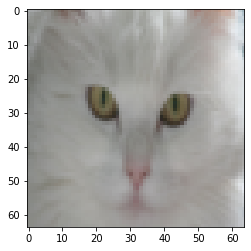

In [81]:
index = 50
plt.imshow(train_set_x_orig[index])

In [82]:
m_train = train_set_y.shape[1] #训练集里图片的数量。
m_test = test_set_y.shape[1] #测试集里图片的数量。
num_px = train_set_x_orig.shape[1] #训练、测试集里面的图片的宽度和高度（均为64x64）。

#现在看一看我们加载的东西的具体情况
print("训练集的数量: m_train = " + str(m_train))
print("测试集的数量 : m_test = " + str(m_test))
print("每张图片的宽/高 : num_px = " + str(num_px))
print("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("训练集_图片的维数 : " + str(train_set_x_orig.shape))
print("训练集_标签的维数 : " + str(train_set_y.shape))
print("测试集_图片的维数: " + str(test_set_x_orig.shape))
print("测试集_标签的维数: " + str(test_set_y.shape))


训练集的数量: m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)
训练集_图片的维数 : (209, 64, 64, 3)
训练集_标签的维数 : (1, 209)
测试集_图片的维数: (50, 64, 64, 3)
测试集_标签的维数: (1, 50)


In [83]:
#X_flatten = X.reshape(X.shape [0]，-1).T ＃X.T是X的转置
#将训练集的维度降低并转置。
train_set_x_flatten  = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
#将测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


In [84]:
print ("训练集降维最后的维度： " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数 : " + str(test_set_y.shape))


训练集降维最后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)


所以我们可以放心的除以255，让标准化的数据位于[0,1]之间，现在标准化我们的数据集

In [85]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

(100, 1)

In [101]:
def sigmoid(z):
    return 1/(1+np.exp(-z))


def initialize_with_zeros(dim):
    
    w = np.zeros((dim,1))
    b = 0
    assert(w.shape==(dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    return (w,b)

def propagate(w,b,X,Y):
    """
    迭代一次
    输入：
    参数w,b X,Y
    输出：
    梯度 损失
    """
    
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X)+b)
    
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db =  (1 / m) * np.sum(A - Y)
    assert(dw.shape==w.shape)
    assert(db.dtype==float)
    cost = np.squeeze(cost)
    assert(cost.shape==())
    
    grads = {"dw":dw,
            "db":db}
    
    return (grads,cost)

def optimize(w,b,X,Y,num_iterations,learning_rate,print_cost=False):
    """
    此函数通过运行梯度下降算法来优化w和b
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值
    
    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。
    
    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """
    costs = []
    
    for i in range(num_iterations):
        grads,cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate*dw
        b = b - learning_rate*db
       
        
    
        #记录成本
        if (i+1)%100 == 0:
            costs.append(cost)
            if print_cost:
                print("迭代的次数: %i ， 误差值： %f" % (i+1,cost))
            
    params  = {
                "w" : w,
                "b" : b }
    grads = {
            "dw": dw,
            "db": db } 
    return (params , grads , costs)
    

def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]
    #正向传播
    A = sigmoid(np.dot(w.T,X) + b) #计算激活值，请参考公式2。
    
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) #计算成本，请参考公式3和4。
    
    #反向传播
    dw = (1 / m) * np.dot(X, (A - Y).T) #请参考视频中的偏导公式。
    db = (1 / m) * np.sum(A - Y) #请参考视频中的偏导公式。

#使用断言确保我的数据是正确的
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    #创建一个字典，把dw和db保存起来。
    grads = {
                "dw": dw,
                "db": db
             }
    return (grads , cost)

    

In [114]:
w,b = initialize_with_zeros(train_set_x_flatten.shape[0])
params,grads,costs = optimize(w,b,train_set_x,train_set_y,2000,0.005,print_cost=True)

迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
迭代的次数: 1000 ， 误差值： 0.214820
迭代的次数: 1100 ， 误差值： 0.203078
迭代的次数: 1200 ， 误差值： 0.192544
迭代的次数: 1300 ， 误差值： 0.183033
迭代的次数: 1400 ， 误差值： 0.174399
迭代的次数: 1500 ， 误差值： 0.166521
迭代的次数: 1600 ， 误差值： 0.159305
迭代的次数: 1700 ， 误差值： 0.152667
迭代的次数: 1800 ， 误差值： 0.146542
迭代的次数: 1900 ， 误差值： 0.140872


In [67]:
params

{'w': array([[ 2.28093108],
        [-5.38716903],
        [-2.4296901 ],
        ...,
        [-2.1832356 ],
        [-5.75083354],
        [ 5.14983644]]),
 'b': 0.012175425148057233}

In [93]:
w,b = initialize_with_zeros(train_set_x_flatten.shape[0])
propagate(w,b,train_set_x_flatten,train_set_y)

({'dw': array([[12.03827751],
         [16.0645933 ],
         [12.55502392],
         ...,
         [12.94019139],
         [15.84210526],
         [ 8.27511962]]),
  'db': 0.15550239234449761},
 0.6931471805599453)

In [69]:
train_set_x_flatten

array([[ 17, 196,  82, ..., 143,  22,   8],
       [ 31, 192,  71, ..., 155,  24,  28],
       [ 56, 190,  68, ..., 165,  23,  53],
       ...,
       [  0,  82, 138, ...,  85,   4,   0],
       [  0,  80, 141, ..., 107,   5,   0],
       [  0,  81, 142, ..., 149,   0,   0]], dtype=uint8)

In [86]:
def sigmoid(z):
    """
    参数：
        z  - 任何大小的标量或numpy数组。
    
    返回：
        s  -  sigmoid（z）
    """
    return 1/(1+np.exp(-z))

In [87]:
sigmoid(38)

1.0

In [88]:
#测试sigmoid()
print("====================测试sigmoid====================")
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))


====================测试sigmoid====================
sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


In [103]:
def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。
        
        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）
        
        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape = (dim,1))
    b = 0
    #使用断言来确保我要的数据是正确的
    assert(w.shape == (dim, 1)) #w的维度是(dim,1)
    assert(isinstance(b, float) or isinstance(b, int)) #b的类型是float或者是int
    
    return (w , b)


In [104]:
def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]
    #正向传播
    A = sigmoid(np.dot(w.T,X) + b) #计算激活值，请参考公式2。
    
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) #计算成本，请参考公式3和4。
    
    #反向传播
    dw = (1 / m) * np.dot(X, (A - Y).T) #请参考视频中的偏导公式。
    db = (1 / m) * np.sum(A - Y) #请参考视频中的偏导公式。

#使用断言确保我的数据是正确的
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    #创建一个字典，把dw和db保存起来。
    grads = {
                "dw": dw,
                "db": db
             }
    return (grads , cost)


In [105]:
def optimize(w , b , X , Y , num_iterations , learning_rate , print_cost = False):
    """
    此函数通过运行梯度下降算法来优化w和b
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值
    
    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。
    
    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        #记录成本
        if i % 100 == 0:
            costs.append(cost)
        #打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 误差值： %f" % (i,cost))
        
    params  = {
                "w" : w,
                "b" : b }
    grads = {
            "dw": dw,
            "db": db } 
    return (params , grads , costs)


In [106]:
def predict(w , b , X ):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据
    
    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）
    
    """
    
    m  = X.shape[1] #图片的数量
    Y_prediction = np.zeros((1,m)) 
    w = w.reshape(X.shape[0],1)
    
    #计预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T , X) + b)
    for i in range(A.shape[1]):
        #将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
    #使用断言
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction


In [107]:
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):
    """
    通过调用之前实现的函数来构建逻辑回归模型
    
    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本
    
    返回：
        d  - 包含有关模型信息的字典。
    """
    w , b = initialize_with_zeros(X_train.shape[0])
    
    parameters , grads , costs = optimize(w , b , X_train , Y_train,num_iterations , learning_rate , print_cost)
    
    #从字典“参数”中检索参数w和b
    w , b = parameters["w"] , parameters["b"]
    
    #预测测试/训练集的例子
    Y_prediction_test = predict(w , b, X_test)
    Y_prediction_train = predict(w , b, X_train)
    
    #打印训练后的准确性
    print("训练集准确性："  , format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100) ,"%")
    print("测试集准确性："  , format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100) ,"%")
    
    d = {
            "costs" : costs,
            "Y_prediction_test" : Y_prediction_test,
            "Y_prediciton_train" : Y_prediction_train,
            "w" : w,
            "b" : b,
            "learning_rate" : learning_rate,
            "num_iterations" : num_iterations }
    return d


In [110]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
迭代的次数: 1000 ， 误差值： 0.214820
迭代的次数: 1100 ， 误差值： 0.203078
迭代的次数: 1200 ， 误差值： 0.192544
迭代的次数: 1300 ， 误差值： 0.183033
迭代的次数: 1400 ， 误差值： 0.174399
迭代的次数: 1500 ， 误差值： 0.166521
迭代的次数: 1600 ， 误差值： 0.159305
迭代的次数: 1700 ， 误差值： 0.152667
迭代的次数: 1800 ， 误差值： 0.146542
迭代的次数: 1900 ， 误差值： 0.140872
训练集准确性： 99.04306220095694 %
测试集准确性： 70.0 %


In [113]:
train_set_x.shape,train_set_x_flatten.shape

((12288, 209), (12288, 209))

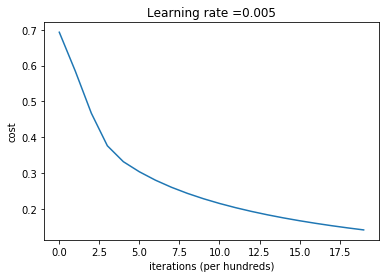

In [24]:
#绘制图
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()


learning rate is: 0.01
训练集准确性： 99.52153110047847 %
测试集准确性： 68.0 %

-------------------------------------------------------

learning rate is: 0.001
训练集准确性： 88.99521531100478 %
测试集准确性： 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
训练集准确性： 68.42105263157895 %
测试集准确性： 36.0 %

-------------------------------------------------------



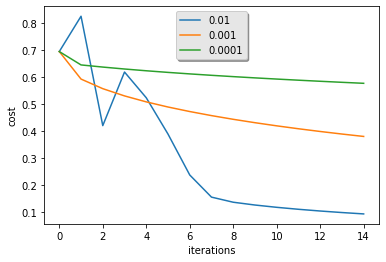

In [34]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()
